# Contrastive Learning: SimCLR

In [47]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
from copy import deepcopy

## Imports for plotting

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()


## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
# %load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [48]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = []
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## SimCLR

### Contrastive Data Augmentation

In [49]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [62]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [63]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, 
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


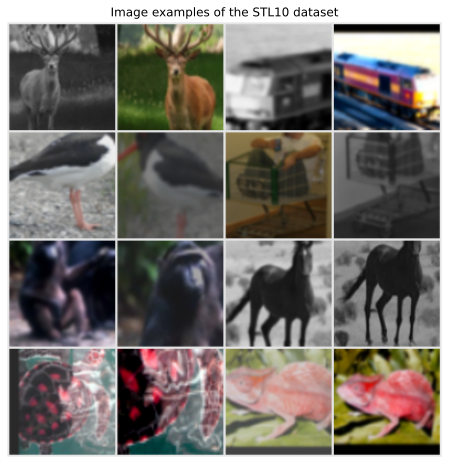

In [66]:
## Code box
#Visualize some examples
NUM_IMAGES = 8
imgs = torch.stack([img for idx in range(10,10+NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=NUM_IMAGES//2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### SimCLR implementation

In [7]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        self.convnet = torchvision.models.resnet18(pretrained=False, num_classes=hidden_dim)
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        #                                               milestones=[140,180], 
        #                                               gamma=0.1)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=500,
                                                            eta_min=1e-5)
        return [optimizer], [lr_scheduler]
        
    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        num_imgs = imgs.shape[0]
        
        feats = self.convnet(imgs)
        
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        pos_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        pos_mask = pos_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        neg_mask = ~pos_mask
        neg_mask.fill_diagonal_(False)

        pos_sim = cos_sim[pos_mask].view(num_imgs, 1)
        neg_sim = cos_sim[neg_mask].view(num_imgs, -1)
        comb_sim = torch.cat([pos_sim, neg_sim], dim=-1)
        nll = -F.log_softmax(comb_sim / self.hparams.temperature, dim=-1)[:,0]
        nll = nll.mean()
        
        self.log(mode+'_loss', nll)

        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        
        return nll
        
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Training

In [8]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=6)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=6)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [9]:
simclr_model = train_simclr(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


## Logistic Regression

In [17]:
class LogisticRegression(pl.LightningModule):
    
    def __init__(self, feature_dim, num_classes, lr, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[60, 80], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]
        
    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss        
        
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')
        
    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [44]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
val_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                     transform=img_transforms)

print("Number of training examples:", len(train_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000


In [19]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)
    
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=6, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
    
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return data.TensorDataset(feats, labels)

In [45]:
train_feats_data = prepare_data_features(simclr_model, train_img_data)
val_feats_data = prepare_data_features(simclr_model, val_img_data)


5000


In [21]:
def train_logreg(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=0,
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=4)
    val_loader = data.DataLoader(val_feats_data, batch_size=batch_size, shuffle=False, 
                                 drop_last=False, pin_memory=True, num_workers=4)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "LogisticRegression.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = LogisticRegression.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation set
    train_result = trainer.test(model, test_dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
        
    return model, result

In [22]:
logreg_model, logreg_result = train_logreg(batch_size=64,
                                           feature_dim=train_feats_data.tensors[0].shape[1],
                                           num_classes=10,
                                           lr=3e-4,
                                           weight_decay=1e-3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 1.3 K 
---------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [24]:
print(logreg_result)

{'train': 0.7806490659713745, 'val': 0.7466250061988831}


## Standard network

In [25]:
class ResNet(pl.LightningModule):
    
    def __init__(self, num_classes, lr, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[60, 80], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]
        
    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss        
        
    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')
        
    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [35]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.2,1.0)),
                                       transforms.RandomApply([
                                           transforms.ColorJitter(brightness=0.3,
                                                                  contrast=0.3,
                                                                  saturation=0.3,
                                                                  hue=0.05)
                                       ], p=0.8),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1,1.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


In [41]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         gpus=1 if str(device)=="cuda:0" else 0,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         progress_bar_refresh_rate=1,
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=4)
    val_loader = data.DataLoader(val_img_data, batch_size=batch_size, shuffle=False, 
                                 drop_last=False, pin_memory=True, num_workers=4)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "LogisticRegression.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation set
    train_result = trainer.test(model, test_dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
        
    return model, result

In [42]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=5e-4,
                                           weight_decay=2e-4,
                                           max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)
Missing logger folder: ../saved_models/tutorial17/ResNet/lightning_logs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Global seed set to 42


Exception in thread Thread-461:
Traceback (most recent call last):
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  Fil

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [43]:
print(resnet_result)

{'train': 0.9210737347602844, 'val': 0.8118749856948853}
